# Sentiment Analysis

## Goal
In this notebook, I will analyze sentiments from input strings using 3 different approaches:
1. Bag of Words approach: VADER (Valence Aware Dictionary and Sentiment Reasoner)
2. Huggingface &#x1F917; pretrained model: Roberta
3. Huggingface more advanced pipeline

## Dataset
The Amazon Reviews dataset is from Kaggle
https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews?resource=download


In [1]:
# Standard Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

# NLTK and huggingface
import nltk
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/hungnguyen/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/hungnguyen/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Init. Read Data and Quick EDA
## Read in Data from CSV file
Please make sure you have the dataset available. It is quite large so be careful.

The dataset essentially has the ID of the reviewer and the **Score**, **Summary** (review title), and **Text** which is the review itself. For this project, we do not care about (nor do we have access to) the products and the users.

In [2]:
df = pd.read_csv('Reviews.csv')
print(df.shape)

(568454, 10)


In [3]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
# To save time, let's go down to 500 reviews to get the conceptuals down
df = df.head(500)
print(df.shape)

(500, 10)


## On-the-surface EDA

Score
1     36
2     18
3     37
4     70
5    339
Name: count, dtype: int64


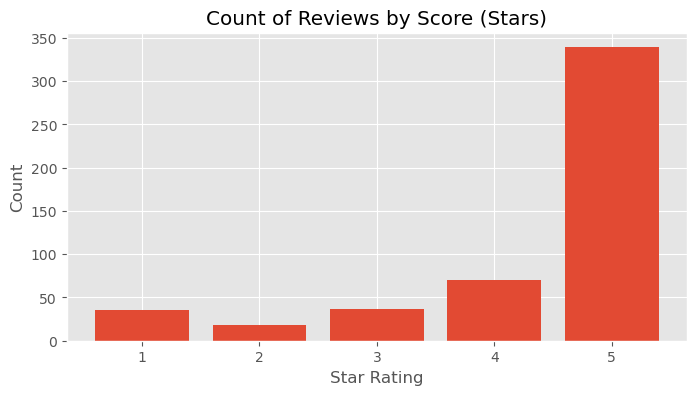

In [5]:
score_count_agg = df['Score'].value_counts().sort_index()
print(score_count_agg)
plt.figure(figsize=(8,4))
plt.bar(score_count_agg.index, score_count_agg)
plt.title('Count of Reviews by Score (Stars)')
plt.xlabel('Star Rating')
plt.ylabel('Count')

plt.show()

## WordCloud

In [6]:
# WordCloud Visualization
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
full_text = " ".join(text for text in df['Text'])
print("There are {} words in the combination of all review.".format(len(full_text)))

There are 185231 words in the combination of all review.


In [7]:
replace_dict = {
    "<br>" : "\n",
    "<br />": "\n"
    
}
for key in replace_dict.keys():
    full_text = full_text.replace(key, replace_dict[key])

In [39]:
full_text[:567]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most. Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo". This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in'

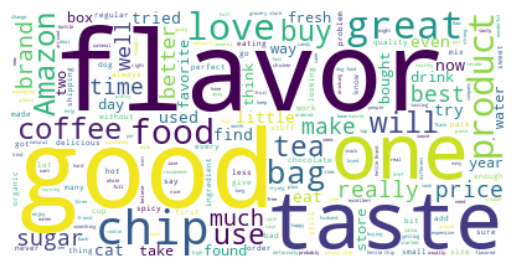

In [9]:
# Create stopword list:
stopwords = set(STOPWORDS)

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(full_text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

We could achieve a better word cloud over each category of items, if we had that kind of categorical data.

In [10]:
# NLTK pre-processing
example = df['Text'][69]
print("Example:", example)
tokens = nltk.word_tokenize(example)
print(tokens)
nltk.pos_tag(tokens)

Example: this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault
['this', 'was', 'sooooo', 'deliscious', 'but', 'too', 'bad', 'i', 'ate', 'em', 'too', 'fast', 'and', 'gained', '2', 'pds', '!', 'my', 'fault']


[('this', 'DT'),
 ('was', 'VBD'),
 ('sooooo', 'JJ'),
 ('deliscious', 'JJ'),
 ('but', 'CC'),
 ('too', 'RB'),
 ('bad', 'JJ'),
 ('i', 'JJ'),
 ('ate', 'NN'),
 ('em', 'NN'),
 ('too', 'RB'),
 ('fast', 'RB'),
 ('and', 'CC'),
 ('gained', 'VBD'),
 ('2', 'CD'),
 ('pds', 'NN'),
 ('!', '.'),
 ('my', 'PRP$'),
 ('fault', 'NN')]

# 1. NLTK Sentiment Analyzer VADER

In [11]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

# initialize object. Can run on text to see what the sentiment is!
sia = SentimentIntensityAnalyzer()

In [12]:
sia.polarity_scores('I am insanely quite annoyed!')

{'neg': 0.515, 'neu': 0.485, 'pos': 0.0, 'compound': -0.4914}

### Iterate over dataset

In [13]:
# Run polarity score on entire dataset
results = dict()
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    idx = row['Id']
    results[idx] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [14]:
# convert results to pandas Dataframe and merge with it
res_vaders = pd.DataFrame(results).T
res_vaders = res_vaders.reset_index().rename(columns={'index':'Id'})
res_vaders = res_vaders.merge(df, how='left')
res_vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Plot Vaders Result

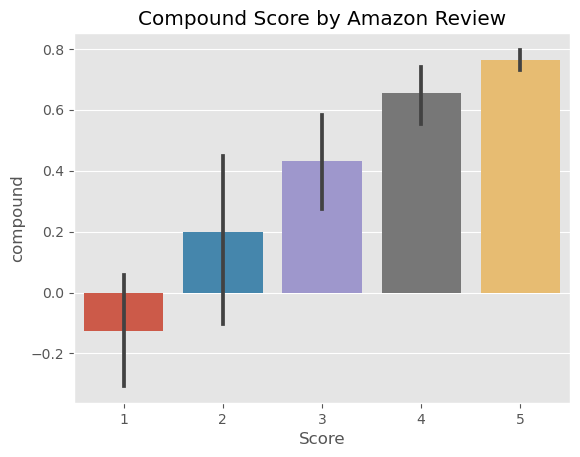

In [15]:
ax = sns.barplot(data = res_vaders, x='Score', y='compound')
ax.set_title('Compound Score by Amazon Review')
plt.show()

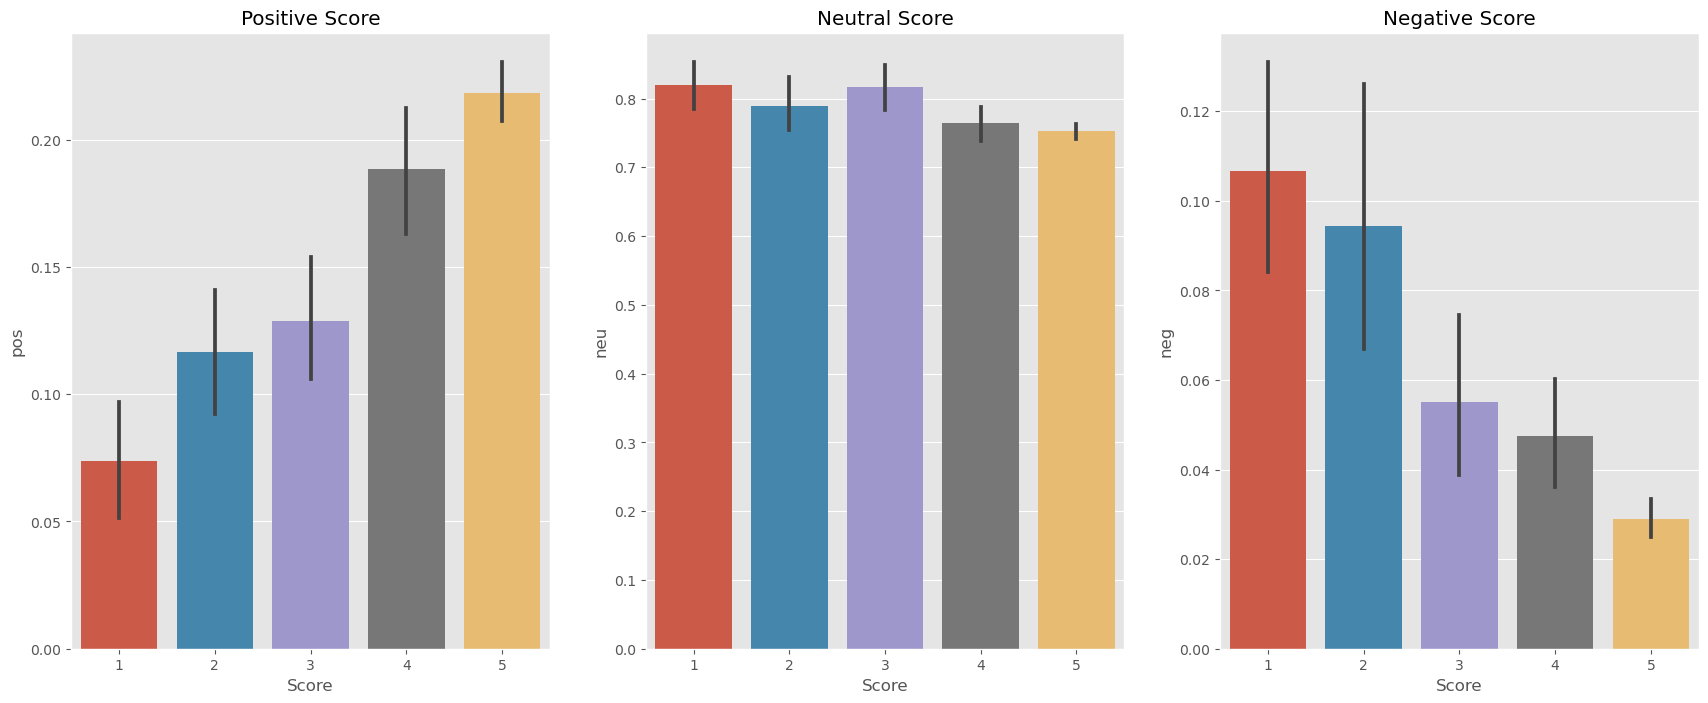

In [16]:
fig, axs = plt.subplots(1, 3, figsize = (21,8))
sns.barplot(data = res_vaders, x='Score', y='pos', ax = axs[0])
sns.barplot(data = res_vaders, x='Score', y='neu', ax = axs[1])
sns.barplot(data = res_vaders, x='Score', y='neg', ax = axs[2])
axs[0].set_title('Positive Score')
axs[1].set_title('Neutral Score')
axs[2].set_title('Negative Score')
plt.show()

# 2. Roberta Pretrained Model
- Use Huggingface's pretrained model that used a large corpus of data.
- Transformer model accounts for words but also the context related to other words. I will retrieve the Tokenizer and Model for this pretrained model. The one I'm using for this exercise is pretrained on Twitter data.

In [17]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [18]:
HF_MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(HF_MODEL)
model = AutoModelForSequenceClassification.from_pretrained(HF_MODEL)

In [19]:
# reminder of the results for VADERS
print(example)
print("VADERS :", sia.polarity_scores(example))

# Process for applying Roberta model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text) # output is a tensor
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'neg': scores[0],
    'neu': scores[1],
    'pos': scores[2]
}

print("ROBERTA:", scores_dict)

this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault
VADERS : {'neg': 0.344, 'neu': 0.52, 'pos': 0.136, 'compound': -0.7345}
ROBERTA: {'neg': 0.96015793, 'neu': 0.035429116, 'pos': 0.0044129724}


In [20]:
def polarity_scores_roberta(text):
    encoded_text = tokenizer(text, return_tensors='pt')
    output = model(**encoded_text) # output is a tensor
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }
    return scores_dict

Compare results from both VADER and Roberta, while ignoring some examples with too much text for the Roberta model to handle.

In [21]:
# Comparing results from both
results = dict()
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        idx = row['Id']
        
        vader_result = sia.polarity_scores(text)

        vader_result_renamed = {}
        for key, value in vader_result.items():
            vader_result_renamed[f"vader_{key}"] = value
        
        roberta_result = polarity_scores_roberta(text)
        
        results[idx] = {**vader_result_renamed, **roberta_result}
    except RuntimeError:
        print(f'Broke for id {idx}')

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187


In [22]:
# sample output
results[1]

{'vader_neg': 0.0,
 'vader_neu': 0.695,
 'vader_pos': 0.305,
 'vader_compound': 0.9441,
 'roberta_neg': 0.009624226,
 'roberta_neu': 0.049980387,
 'roberta_pos': 0.94039536}

In [23]:
results_df = pd.DataFrame(results).T
results_df = results_df.reset_index().rename(columns={'index':'Id'})
results_df = results_df.merge(df, how='left')
results_df.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Graph for comparison between models

In [24]:
# All columns
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [25]:
# Watch out for typos
ys = ['vader_neg', 'vader_neu', 'vader_pos',
     'roberta_neg', 'roberta_neu', 'roberta_pos']

/Users/hungnguyen/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


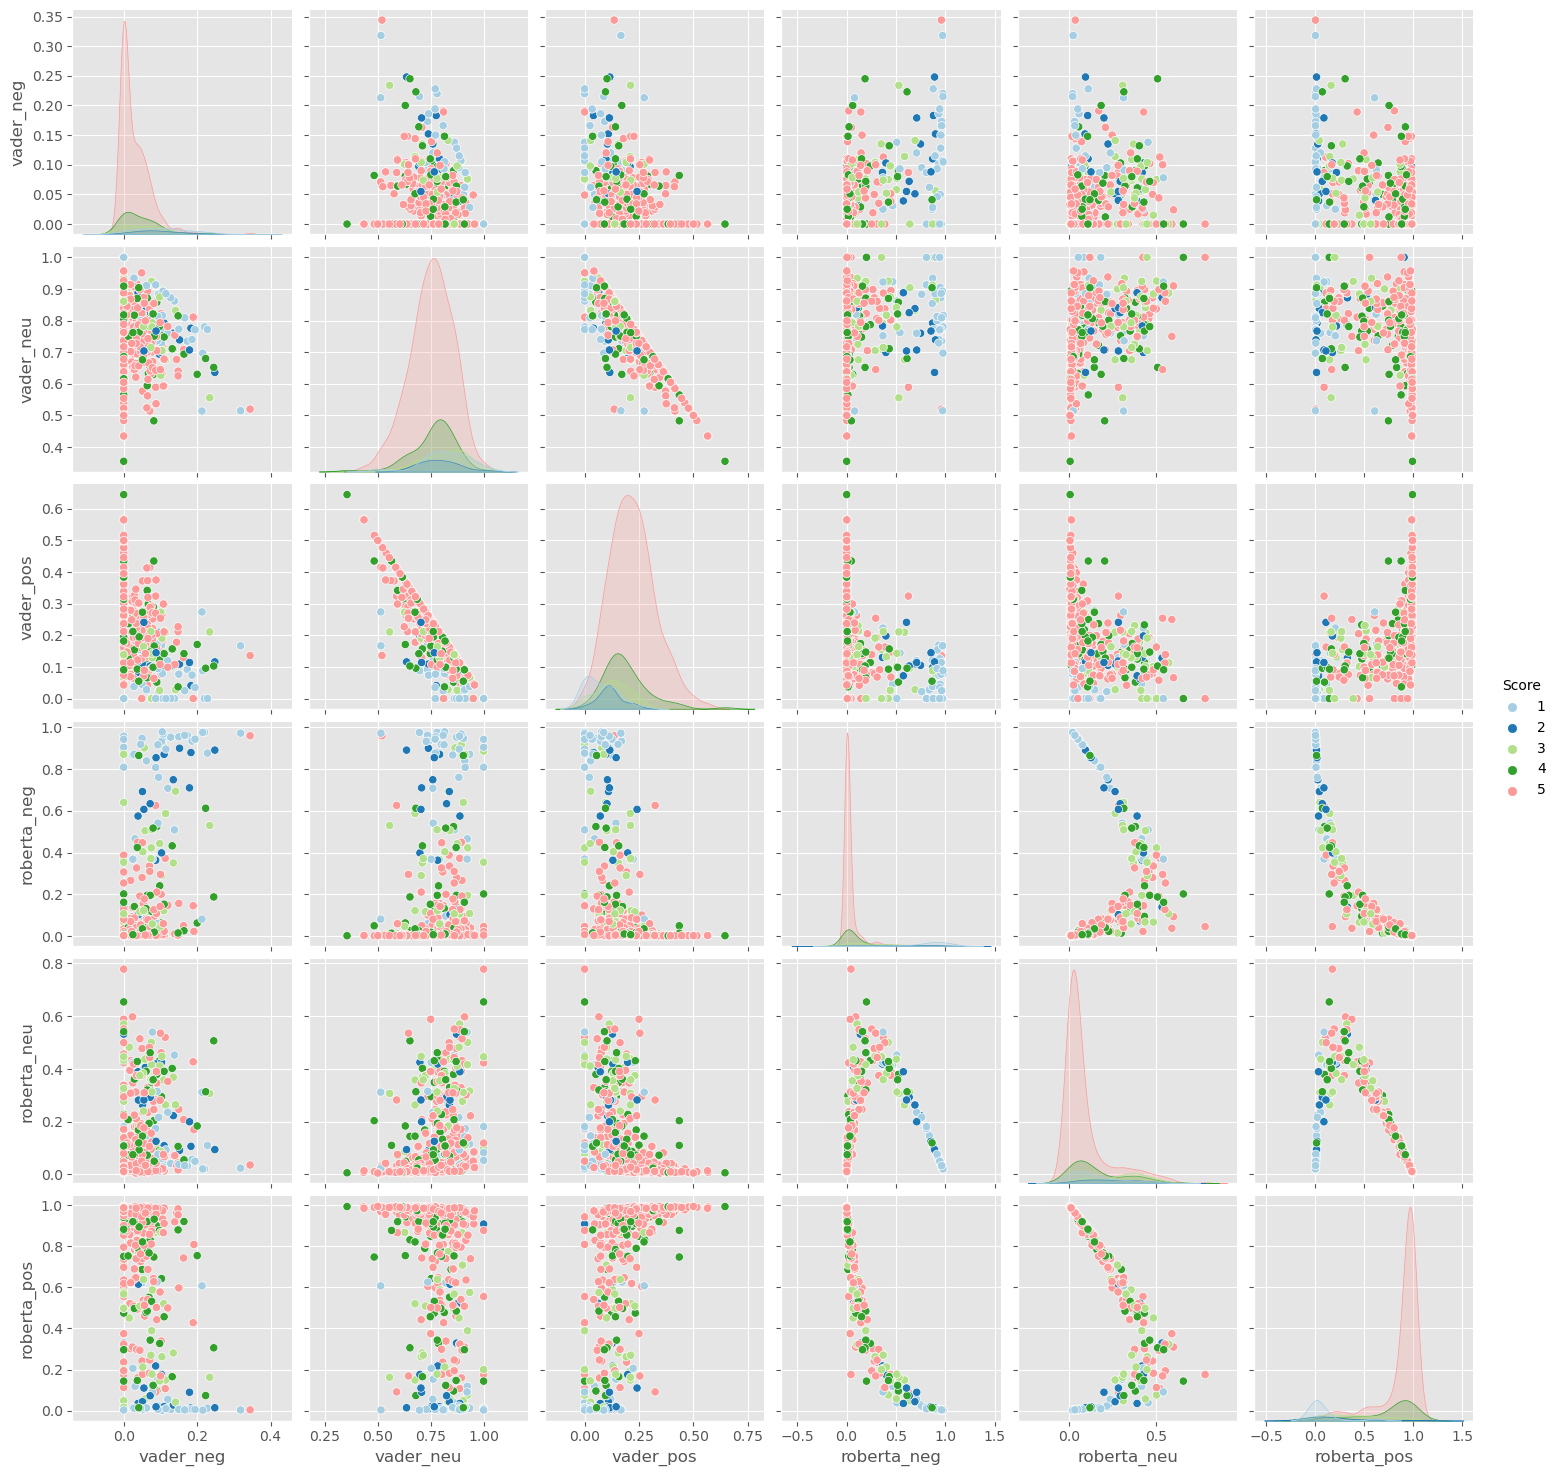

In [26]:
sns.pairplot(data = results_df,
            vars = ys,
            hue = 'Score',
            palette = 'Paired')
plt.show()

# 4. Review some samples
Let's try looking at some specific "strange" cases:
- Positive 1-Star reviews
- Negative 5-star Reviews

## Positive 1-star reviews

In [27]:
results_df.query('Score == 1').sort_values('roberta_pos', ascending=False)['Text'].values[0]

'I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.'

The model is probably confused because the review is dabling between likely "positive" keywords like "were actually" and neutral words like "intended". Either way, us humans can tell that it is a negative comment due to the overall context that it is supposed to be labeled "Jumbo", which these models are not really good at identifying.

Another similar case to this is asking for the number of r's in "strawberry".

Let's try with VADER:

In [28]:
results_df.query('Score == 1').sort_values('vader_pos', ascending=False)['Text'].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

Well, this is a bit more obvious to tell because there are many positive indicators here.
- "without any problem"
- "positive note"

But again, it lacks the complete understanding of context that canceling an order is a BAD sign for this task. If this was customer service review sentiment analysis, then this would have been correctly identified as positive.

## Negative 5-star reviews
Similarly, we can see the interesting mistakes that might cause the models to predict incorrect. This sort of shows that language is very cultural and contextual, such that identifying the conveyed *tone* through mere words proves to be challenging. This is also why "sarcasm detection" is so difficult... even humans have a hard time identifying sarcasm unless given massive amount of context.

In [29]:
results_df.query('Score == 5').sort_values('roberta_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [30]:
results_df.query('Score == 5').sort_values('vader_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

# 5. The Transformers Pipeline
This is just a test to use sentiment prediction pipeline by huggingface

In [31]:
from transformers import pipeline

sentiment_pipeline = pipeline("sentiment-analysis")

# we can now run the model in 2 lines of code

2024-09-19 23:23:57.273146: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [32]:
sentiment_pipeline('This is barely good!')

[{'label': 'NEGATIVE', 'score': 0.9993320107460022}]

In [33]:
sentiment_pipeline('How are we not using this?')

[{'label': 'NEGATIVE', 'score': 0.9993298053741455}]

In [34]:
test_text = 'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'
sentiment_pipeline(test_text)

[{'label': 'POSITIVE', 'score': 0.9988051652908325}]

In [35]:
sentiment_pipeline('We had to SADLY cancel the order did not make it to our post office. ' + test_text)

[{'label': 'POSITIVE', 'score': 0.996792733669281}]

In [36]:
bad_sentiment = 'This is horrible.'
sentiment_pipeline(bad_sentiment + ' We had to SADLY cancel the order did not make it to our post office. ' + test_text)

[{'label': 'POSITIVE', 'score': 0.758233368396759}]